# The purpose of this script is to pull data from the 2021 MICCAI and rank the papers by review score

In [29]:
from bs4 import BeautifulSoup
import urllib.request as urllib2
import shutil
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

miccai_base_url = 'https://miccai2021.org/openaccess/paperlinks/'


### Get list of all papers

In [2]:
req = urllib2.Request(miccai_base_url, headers=headers)
page = urllib2.urlopen(req)
content = page.read()

In [3]:
soup = BeautifulSoup(content, 'html.parser')
paper_list_soup = soup.find_all('span', attrs={'class': 'posts-list-item-name float-left'})
paper_list = []

for paper in paper_list_soup:
    
    href = paper.find('a',href=True)['href']
    title = paper.find('a',href=True).text
    
    paper_list.append( (href, title) )

### Process papers

In [4]:
paper_metadata = {}
for i, paper in enumerate(paper_list):
    print(i, len(paper_list), paper)
    paper_name = paper[1]
    paper_url = miccai_base_url + paper[0]
    
    req = urllib2.Request(paper_url, headers=headers)
    page = urllib2.urlopen(req)
    content = page.read()
    
    
    soup = BeautifulSoup(content, 'html.parser')
    
    post_categories = soup.find('div', attrs= {'class', 'post-categories'})
    category_soup = post_categories.find_all('a', attrs={'class':'post-category'})
    
    paper_categories = set()
    for category in category_soup:
        paper_categories.add(category.text.strip())
    
    
    code_element = soup.find('h1', attrs={'id':'code-id'})
    code_url = code_element.findNext('p').text.strip()
    if code_url == 'N/A':
        code_url = None
    
    
    
    clarity_and_organization = []
    for x in soup.find_all('li'):
        if 'Please rate the clarity and organization of this paper' in x.text:
            if x.find('p') is None:
                continue      
            clarity_and_organization.append(x.find('p').text)
    
    overall_opinion = []
    for x in soup.find_all('li'):
        if 'Please state your overall opinion of the paper' in x.text:
            if x.find('p') is None:
                continue  
            overall_opinion.append(float(x.find('p').text.split(' ')[-1].replace('(','').replace(')','')))
    
    reviewer_confidence = []
    for x in soup.find_all('li'):
        if 'Reviewer confidence' in x.text:
            if x.find('p') is None:
                continue  
            reviewer_confidence.append(x.find('p').text)
               
    ranking_of_paper_in_stack = []
    for x in soup.find_all('li'):
        if 'What is the ranking of this paper in your review stack?' in x.text:
            if x.find('p') is None:
                continue  
            ranking_of_paper_in_stack.append(float(x.find('p').text))
            
            
    number_of_papers_in_stack = []
    for x in soup.find_all('li'):
        if 'Number of papers in your stack' in x.text:
            if x.find('p') is None:
                continue  
            number_of_papers_in_stack.append(float(x.find('p').text))
            
            
    paper_metadata[paper] = {}
    paper_metadata[paper]['paper_categories'] = paper_categories
    paper_metadata[paper]['clarity_and_organization'] = clarity_and_organization
    paper_metadata[paper]['overall_opinion'] = overall_opinion
    paper_metadata[paper]['reviewer_confidence'] = reviewer_confidence
    paper_metadata[paper]['ranking_of_paper_in_stack'] = ranking_of_paper_in_stack
    paper_metadata[paper]['number_of_papers_in_stack'] = number_of_papers_in_stack
    paper_metadata[paper]['code_url'] = code_url
    paper_metadata[paper]['paper_url'] = paper_url
    

0 531 ('2021/09/01/001-Paper1891.html', '2.5D Thermometry Maps for MRI-guided Tumor Ablation')
1 531 ('2021/09/01/002-Paper0547.html', '2D Histology Meets 3D Topology: Cytoarchitectonic Brain Mapping with Graph Neural Networks')
2 531 ('2021/09/01/003-Paper1706.html', '3D Brain Midline Delineation for Hematoma Patients')
3 531 ('2021/09/01/004-Paper0943.html', '3D Graph-S2Net: Shape-Aware Self-Ensembling Network for Semi-Supervised Segmentation with Bilateral Graph Convolution')
4 531 ('2021/09/01/005-Paper0364.html', '3D Semantic Mapping from Arthroscopy using Out-of-distribution Pose and Depth and In-distribution Segmentation Training')
5 531 ('2021/09/01/006-Paper1154.html', '3D Transformer-GAN for High-quality PET Reconstruction')
6 531 ('2021/09/01/007-Paper1688.html', '3D-UCaps: 3D Capsules Unet for Volumetric Image Segmentation')
7 531 ('2021/09/01/008-Paper0889.html', '4D-CBCT Registration with a FBCT-derived Plug-and-Play Feasibility Regularizer')
8 531 ('2021/09/01/009-Paper2

64 531 ('2021/09/01/065-Paper1657.html', 'Automatic Severity Rating for Improved Psoriasis Treatment')
65 531 ('2021/09/01/066-Paper1844.html', 'Automating Embryo Development Stage Detection in Time-Lapse Imaging with Synergic Loss and Temporal Learning')
66 531 ('2021/09/01/067-Paper0438.html', 'AxonEM Dataset: 3D Axon Instance Segmentation of Brain Cortical Regions')
67 531 ('2021/09/01/068-Paper0936.html', 'Balanced-MixUp for highly imbalanced medical image classification')
68 531 ('2021/09/01/069-Paper0705.html', 'Bayesian Atlas Building with Hierarchical Priors for Subject-specific Regularization')
69 531 ('2021/09/01/070-Paper0562.html', 'Beyond COVID-19 Diagnosis: Prognosis with Hierarchical Graph Representation Learning')
70 531 ('2021/09/01/071-Paper0966.html', 'Beyond Non-Maximum Suppression - Detecting Lesions in Digital Breast Tomosynthesis Volumes')
71 531 ('2021/09/01/072-Paper2071.html', 'BI-RADS Classification of Calcification on Mammograms')
72 531 ('2021/09/01/073-Pap

127 531 ('2021/09/01/128-Paper1554.html', 'DC-Net: Dual Context Network for 2D Medical Image Segmentation')
128 531 ('2021/09/01/129-Paper1547.html', 'Deep Fiber Clustering: Anatomically Informed Unsupervised Deep Learning for Fast and Effective White Matter Parcellation')
129 531 ('2021/09/01/130-Paper2357.html', 'Deep Iterative 2D/3D Registration')
130 531 ('2021/09/01/131-Paper1539.html', 'Deep J-Sense: Accelerated MRI Reconstruction via Unrolled Alternating Optimization')
131 531 ('2021/09/01/132-Paper1906.html', 'Deep Neural Dynamic Bayesian Networks applied to EEG sleep spindles modeling')
132 531 ('2021/09/01/133-Paper0101.html', 'Deep Open Snake Tracker for Vessel Tracing ')
133 531 ('2021/09/01/134-Paper0234.html', 'Deep Orthogonal Fusion: Multimodal Prognostic Biomarker Discovery Integrating Radiology, Pathology, Genomic, and Clinical Data')
134 531 ('2021/09/01/135-Paper1987.html', 'Deep Reinforcement Exemplar Learning for Annotation Refinement')
135 531 ('2021/09/01/136-Pap

187 531 ('2021/09/01/188-Paper0526.html', 'Fairness in Cardiac MR Image Analysis: An Investigation of Bias Due to Data Imbalance in Deep Learning Based Segmentation')
188 531 ('2021/09/01/189-Paper0428.html', 'Fast Magnetic Resonance Imaging on Regions of Interest: From Sensing to Reconstruction')
189 531 ('2021/09/01/190-Paper2060.html', 'Federated Contrastive Learning for Decentralized Unlabeled Medical Images')
190 531 ('2021/09/01/191-Paper2051.html', 'Federated Contrastive Learning for Volumetric Medical Image Segmentation')
191 531 ('2021/09/01/192-Paper0299.html', 'Federated Semi-supervised Medical Image Classification via Inter-client Relation Matching')
192 531 ('2021/09/01/193-Paper1531.html', 'Federated Whole Prostate Segmentation in MRI with Personalized Neural Architectures')
193 531 ('2021/09/01/194-Paper1236.html', 'FedPerl: Semi-Supervised Peer Learning for Skin Lesion Classification')
194 531 ('2021/09/01/195-Paper2004.html', 'Few Trust Data Guided Annotation Refinemen

249 531 ('2021/09/01/250-Paper0425.html', 'Interactive smoothing parameter optimization in DBT Reconstruction using Deep learning')
250 531 ('2021/09/01/251-Paper1892.html', 'Interhemispheric functional connectivity in the primary motor cortex distinguishes between training on a physical and a virtual surgical simulator')
251 531 ('2021/09/01/252-Paper1908.html', 'Interpretable deep learning for multimodal super-resolution of medical images')
252 531 ('2021/09/01/253-Paper1243.html', 'Interpretable gender classification from retinal fundus images using BagNets')
253 531 ('2021/09/01/254-Paper2287.html', 'Inter-Regional High-level Relation Learning from Functional Connectivity via Self-Supervision')
254 531 ('2021/09/01/255-Paper0306.html', 'Intracerebral Haemorrhage Growth Prediction Based on Displacement Vector Field and Clinical Metadata')
255 531 ('2021/09/01/256-Paper2314.html', 'Intra-operative Update of Boundary Conditions for Patient-specific Surgical Simulation')
256 531 ('2021

311 531 ('2021/09/01/312-Paper1888.html', 'Modality-aware Mutual Learning for Multi-modal Medical Image Segmentation')
312 531 ('2021/09/01/313-Paper2299.html', 'MorphSet: Improving Renal Histopathology Case Assessment Through Learned Prognostic Vectors')
313 531 ('2021/09/01/314-Paper0948.html', 'Motion Correction for Liver DCE-MRI with Time-Intensity Curve Constraint')
314 531 ('2021/09/01/315-Paper1374.html', 'MouseGAN: GAN-Based Multiple MRI Modalities Synthesis and Segmentation for Mouse Brain Structures')
315 531 ('2021/09/01/316-Paper1934.html', 'MRI Super-Resolution Through Generative Degradation Learning')
316 531 ('2021/09/01/317-Paper0251.html', 'M-SEAM-NAM: Multi-instance Self-supervised Equivalent Attention Mechanism with Neighborhood Affinity Module for Double Weakly Supervised Segmentation of COVID-19')
317 531 ('2021/09/01/318-Paper0678.html', 'MT-UDA: Towards Unsupervised Cross-Modality Medical Image Segmentation with Limited Source Labels')
318 531 ('2021/09/01/319-Pa

374 531 ('2021/09/01/375-Paper1325.html', 'Predicting Symptoms from Multiphasic MRI via Multi-Instance Attention Learning for Hepatocellular Carcinoma Grading')
375 531 ('2021/09/01/376-Paper2471.html', 'Primary Tumor and Inter-Organ Augmentations for Supervised Lymph Node Colon Adenocarcinoma Metastasis Detection')
376 531 ('2021/09/01/377-Paper1741.html', 'Pristine annotations-based multi-modal trained artificial intelligence solution to triage chest X-Ray for COVID19')
377 531 ('2021/09/01/378-Paper0320.html', 'Progressively Normalized Self-Attention Network for Video Polyp Segmentation')
378 531 ('2021/09/01/379-Paper1510.html', 'Projection-wise Disentangling for Fair and Interpretable Representation Learning: Application to 3D Facial Shape Analysis')
379 531 ('2021/09/01/380-Paper1305.html', 'Projective Skip-Connections for Segmentation Along a Subset of Dimensions in Retinal OCT')
380 531 ('2021/09/01/381-Paper1809.html', 'Prototypical Interaction Graph for Unsupervised Domain Ad

437 531 ('2021/09/01/438-Paper1185.html', 'Sequential Learning on Liver Tumor Boundary Semantics and Prognostic Biomarker Mining')
438 531 ('2021/09/01/439-Paper1814.html', 'Sequential Lung Nodule Synthesis using Attribute-guided Generative Adversarial Networks')
439 531 ('2021/09/01/440-Paper0423.html', 'SGNet: Structure-aware Graph-based Network for Airway Semantic Segmentation')
440 531 ('2021/09/01/441-Paper2335.html', 'Shallow Attention Network for Polyp Segmentation')
441 531 ('2021/09/01/442-Paper2380.html', 'Sharpening Local Interpretable Model-agnostic Explanations for Histopathology: Improved Understandability and Reliability')
442 531 ('2021/09/01/443-Paper0569.html', 'SimTriplet: Simple Triplet Representation Learning with a Single GPU')
443 531 ('2021/09/01/444-Paper1968.html', 'Simultaneous Alignment and Surface Regression Using Hybrid 2D-3D Networks for 3D Coherent Layer Segmentation of Retina OCT Images')
444 531 ('2021/09/01/445-Paper0395.html', 'Sli2Vol: Annotate a 3D

498 531 ('2021/09/01/499-Paper1147.html', 'Tripled-uncertainty Guided Mean Teacher model for Semi-supervised Medical Image Segmentation')
499 531 ('2021/09/01/500-Paper1373.html', 'Triplet-Branch Network with Prior-Knowledge Embedding for Fatigue Fracture Grading')
500 531 ('2021/09/01/501-Paper1885.html', 'TumorCP: A Simple but Effective Object-Level Data Augmentation for Tumor Segmentation')
501 531 ('2021/09/01/502-Paper2064.html', 'TUN-Det: A Novel Network for Thyroid Ultrasound Nodule Detection')
502 531 ('2021/09/01/503-Paper2411.html', 'TVnet: Automated Time-Resolved Tracking of the Tricuspid Valve Plane in MRI Long-Axis Cine Images with a Dual-Stage Deep Learning Pipeline')
503 531 ('2021/09/01/504-Paper0051.html', 'Two-Stage Self-Supervised Cycle-Consistency Network for Reconstruction of Thin-Slice MR Images')
504 531 ('2021/09/01/505-Paper1201.html', 'U-DuDoNet: Unpaired dual-domain network for CT metal artifact reduction')
505 531 ('2021/09/01/506-Paper0702.html', 'Ultrasoun

### Extract paper metadata

In [21]:
paper_metadata_dict = {}

for ii, paper in enumerate(paper_list):
    print(ii)
    
    
    paper_url = miccai_base_url + paper[0]
    
    req = urllib2.Request(paper_url, headers=headers)
    page = urllib2.urlopen(req)
    content = page.read()
    soup = BeautifulSoup(content, 'html.parser')
    
    post_categories = soup.find('div', attrs= {'class', 'post-categories'})
    category_soup = post_categories.find_all('a', attrs={'class':'post-category'})
    
    code_element = soup.find('h1', attrs={'id':'code-id'})
    code_url = code_element.findNext('p').text.strip()
    if code_url == 'N/A':
        code_url = None
        
    
    clarity_and_organization = []
    for x in soup.find_all('li'):
        if 'Please rate the clarity and organization of this paper' in x.text:
            clarity_and_organization.append(x.find('p').text)
    
    overall_opinion = []
    for x in soup.find_all('li'):
        if 'Please state your overall opinion of the paper' in x.text:
            overall_opinion.append(float(x.find('p').text.split(' ')[-1].replace('(','').replace(')','')))
    
    ranking_of_paper_in_stack = []
    for x in soup.find_all('li'):
        if 'What is the ranking of this paper in your review stack?' in x.text:
            ranking_of_paper_in_stack.append(float(x.find('p').text))
    
    number_of_papers_in_stack = []
    for x in soup.find_all('li'):
        if 'Number of papers in your stack' in x.text:
            number_of_papers_in_stack.append(float(x.find('p').text))
    
    reviewer_confidence = []
    for x in soup.find_all('li'):
        if 'Reviewer confidence' in x.text:
            reviewer_confidence.append(x.find('p').text)
    
    categories = []
    for category in category_soup:
        categories.append(category.text.strip())
    
    paper_metadata_dict[paper[1]] = {}
    paper_metadata_dict[paper[1]]['paper_url'] = paper_url
    paper_metadata_dict[paper[1]]['code_url'] = code_url
    paper_metadata_dict[paper[1]]['clarity_and_organization'] = clarity_and_organization
    paper_metadata_dict[paper[1]]['overall_opinion'] = overall_opinion
    paper_metadata_dict[paper[1]]['ranking_of_paper_in_stack'] = ranking_of_paper_in_stack
    paper_metadata_dict[paper[1]]['number_of_papers_in_stack'] = number_of_papers_in_stack
    paper_metadata_dict[paper[1]]['reviewer_confidence'] = reviewer_confidence
    paper_metadata_dict[paper[1]]['categories'] = categories
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'NoneType' object has no attribute 'text'

### Save data

In [22]:
with open('data/2021_miccai_paper_metadata_dict.pkl', 'wb') as file:
    pickle.dump(paper_metadata_dict,file)

### Count occurrence of categories

In [24]:
category_counts = {}
for paper_title in paper_metadata_dict:
    paper = paper_metadata_dict[paper_title]
    for category in paper['categories']:
        if category not in category_counts:
            category_counts[category] = 0
        category_counts[category] += 1
        
sorted_category_counts = {k: v for k, v in sorted(category_counts.items(), key=lambda item: -item[1])}

for category in sorted_category_counts:
    print(sorted_category_counts[category], category)

129 Image Segmentation
114 Computer Aided Diagnosis
90 Modalities - MRI
64 Modalities - CT
49 Machine Learning - Self-supervised learning
44 Outcome/disease prediction
44 Machine Learning - Domain adaptation
39 Image Reconstruction
37 Machine Learning - Weakly supervised learning
36 Machine Learning - Interpretability / Explainability
35 Machine Learning - Semi-supervised learning
35 Modalities - other
35 Machine Learning - Attention models
31 Image-Guided Interventions and Surgery
31 Modalities - Histopathology
30 Computational (Integrative) Pathology
29 Clinical applications - Lung
27 Clinical applications - Oncology
26 Image Registration
22 Clinical applications - Abdomen
21 Modalities - Ultrasound
20 Modalities - Microscopy
20 Clinical applications - Neuroimaging - Others
20 Clinical applications - Ophthalmology
19 Clinical applications - Cardiac
17 Modalities - Video
16 Visualisation in Biomedical Imaging
16 Machine Learning - Uncertainty
15 Surgical Planning and Simulation
14 Int

### Do the following: 1) filter papers to those containing specific categories, 2) rank papers based on average review scores

In [38]:
category_counts = {}

category_filters = []
#category_filters = ['Machine Learning - Semi-supervised learning']

filtered_papers = []
for paper_title in paper_metadata_dict:
    paper = paper_metadata_dict[paper_title]
    paper['paper_title'] = paper_title
    
    found_categories = True
    for category_filter in category_filters:
        if category not in paper['categories']:
            found_categories = False
    
    if found_categories == False:
        continue
        
    average_rating = np.mean(paper['overall_opinion'])
    
    
    filtered_papers.append( (average_rating, paper))

sorted_filtered_papers = sorted(filtered_papers, key=lambda paper: paper[0], reverse=True)
average_ratings = [x[0] for x in filtered_papers]


paper_index = 0
for average_rating, paper in sorted_filtered_papers:
    paper_index += 1
    
    print('paper number: %d' % (paper_index))
    print('Title:', paper['paper_title'])
    print('Average Rating:', average_rating)
    print('Paper URL:', paper['paper_url'])
    print('Code:', paper['code_url'])
    print('Categories:', paper['categories'])

    
    print('\n\n\n')
    
    
    if paper_index > 30:
        break


paper number: 1
Title: Detecting when pre-trained nnU-Net models fail silently for Covid-19 lung lesion segmentation
Average Rating: 8.666666666666666
Paper URL: https://miccai2021.org/openaccess/paperlinks/2021/09/01/147-Paper1378.html
Code: https://github.com/MECLabTUDA/Lifelong-nnUNet
Categories: ['Clinical applications - Lung', 'Image Segmentation', 'Machine Learning - Uncertainty', 'Modalities - CT']




paper number: 2
Title: Do we need complex image features to personalize treatment of patients with locally advanced rectal cancer?
Average Rating: 8.666666666666666
Paper URL: https://miccai2021.org/openaccess/paperlinks/2021/09/01/157-Paper1462.html
Code: None
Categories: ['Clinical applications - Oncology', 'Modalities - CT', 'Modalities - MRI', 'Outcome/disease prediction']




paper number: 3
Title: Hierarchical graph pathomic network for progression free survival prediction
Average Rating: 8.666666666666666
Paper URL: https://miccai2021.org/openaccess/paperlinks/2021/09/01/21

### Plot average rating histogram

Text(0.5, 1.0, 'Histogram of paper average rating')

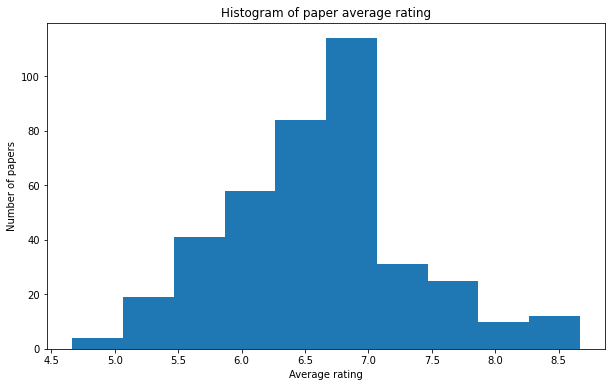

In [37]:
plt.figure(figsize=(10,6))
plt.hist(average_ratings)
plt.xlabel('Average rating')
plt.ylabel('Number of papers')
plt.title('Histogram of paper average rating')